# Dataset Loading

In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 97% 641M/663M [00:09<00:00, 24.0MB/s]
100% 663M/663M [00:09<00:00, 75.3MB/s]


In [ ]:
import zipfile
zf = "/content/tuberculosis-tb-chest-xray-dataset.zip"
target_dir = "/content/dataset/cnn/tuberculosis_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio(
    "/content/dataset/cnn/tuberculosis_revamped/TB_Chest_Radiography_Database",
    output="/content/dataset/cnn/tuberculosis",
    seed=1337,
    ratio=(.7, .2, .1),
    group_prefix=None
)


Copying files: 4200 files [00:05, 828.84 files/s]


In [ ]:
!rm -r "/content/dataset/cnn/tuberculosis_revamped"

In [ ]:
# !mv  -v /content/dataset/cnn/tuberculosis/test/Normal/* /content/dataset/cnn/tuberculosis/test/
# !mv  -v /content/dataset/cnn/tuberculosis/test/Tuberculosis/* /content/dataset/cnn/tuberculosis/test/
# !rm -r /content/dataset/cnn/tuberculosis/test/Normal
# !rm -r /content/dataset/cnn/tuberculosis/test/Tuberculosis

# Data preparation and Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/dataset/cnn/tuberculosis/train'
test_path = '/content/dataset/cnn/tuberculosis/test'
valid_path = '/content/dataset/cnn/tuberculosis/val'

In [ ]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 2939 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


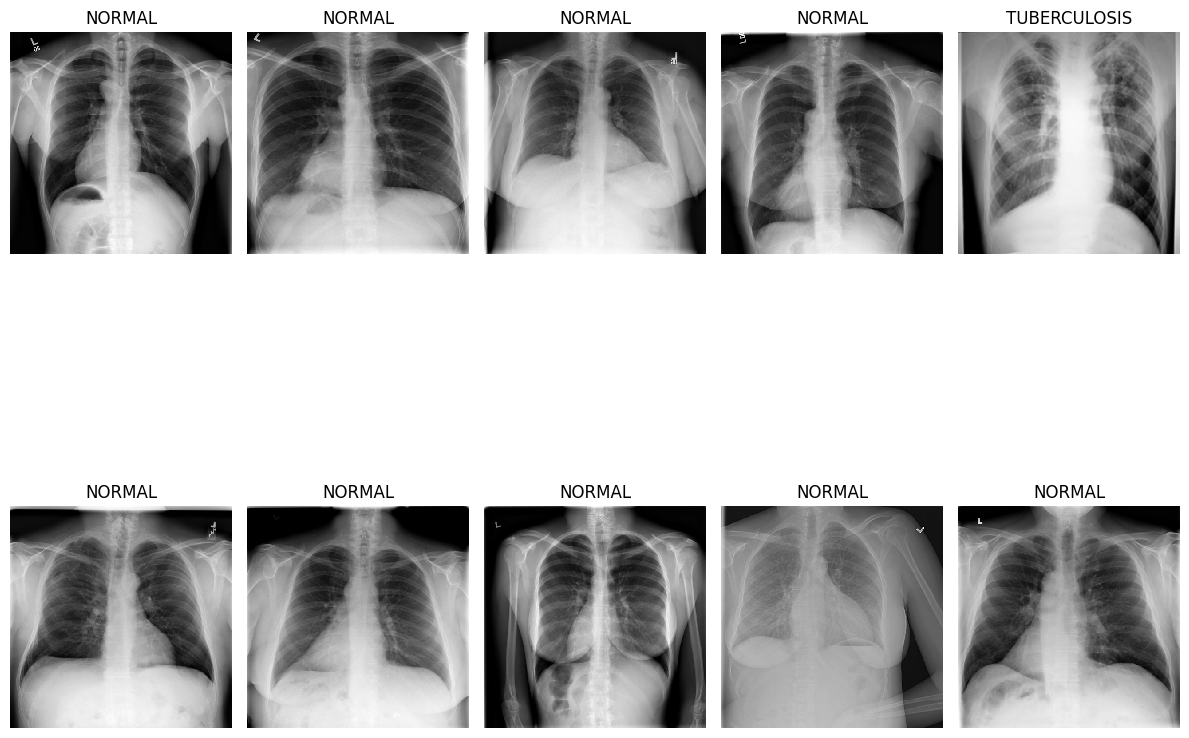

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Model Development and Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 249, 249, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 32)       

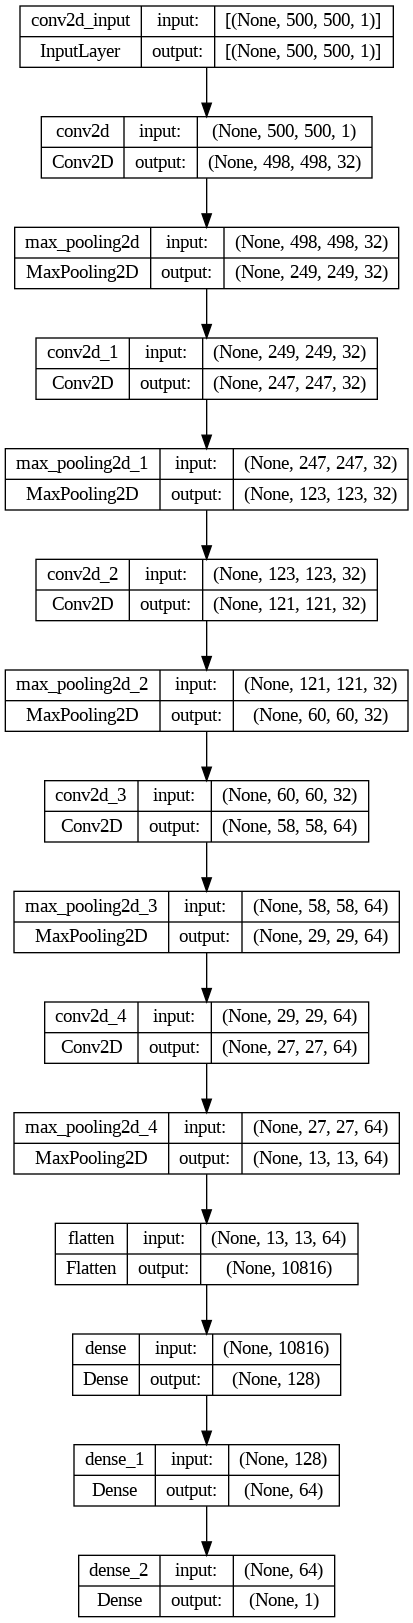

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight="balanced", classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 0.5997959183673469, 1: 3.005112474437628}


In [ ]:
np.unique(train.classes)

array([0, 1], dtype=int32)

In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
184/184 [==============================] - 55s 245ms/step - loss: 0.4745 - accuracy: 0.7805 - val_loss: 0.2371 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 2/25
184/184 [==============================] - 40s 219ms/step - loss: 0.3257 - accuracy: 0.8619 - val_loss: 0.1763 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 3/25
184/184 [==============================] - 40s 218ms/step - loss: 0.2245 - accuracy: 0.8979 - val_loss: 0.1659 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 4/25
184/184 [==============================] - 40s 217ms/step - loss: 0.2007 - accuracy: 0.9234 - val_loss: 0.1922 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 5/25
184/184 [==============================] - 40s 217ms/step - loss: 0.1545 - accuracy: 0.9374 - val_loss: 0.6715 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 6/25
184/184 [==============================] - 43s 235ms/step - loss: 0.1454 - accuracy: 0.9439 - val_loss: 0.2855 - val_accuracy: 0.9298 - lr: 0.0010
Epoch 7/25
184/184 [==============================] 

In [ ]:
import os
import shutil

# Path to the test folder
test_folder_path = "/content/dataset/cnn/tuberculosis/test"

# Create new folders for Normal and Tuberculosis images
normal_folder_path = os.path.join(test_folder_path, "Normal")
tuberculosis_folder_path = os.path.join(test_folder_path, "Tuberculosis")

os.makedirs(normal_folder_path, exist_ok=True)
os.makedirs(tuberculosis_folder_path, exist_ok=True)

# Move Normal images to the Normal folder
for file in os.listdir(test_folder_path):
    if file.startswith("Normal") and os.path.isfile(os.path.join(test_folder_path, file)):
        source_path = os.path.join(test_folder_path, file)
        destination_path = os.path.join(normal_folder_path, file)
        shutil.move(source_path, destination_path)

# Move Tuberculosis images to the Tuberculosis folder
for file in os.listdir(test_folder_path):
    if file.startswith("Tuberculosis") and os.path.isfile(os.path.join(test_folder_path, file)):
        source_path = os.path.join(test_folder_path, file)
        destination_path = os.path.join(tuberculosis_folder_path, file)
        shutil.move(source_path, destination_path)

print("Images moved successfully!")


Images moved successfully!


In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

27/27 [==============================] - 6s 212ms/step - loss: 0.1930 - accuracy: 0.9335
The testing accuracy is : 93.34917068481445 %


In [ ]:
preds = cnn.predict(test,verbose=1)

27/27 [==============================] - 7s 234ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

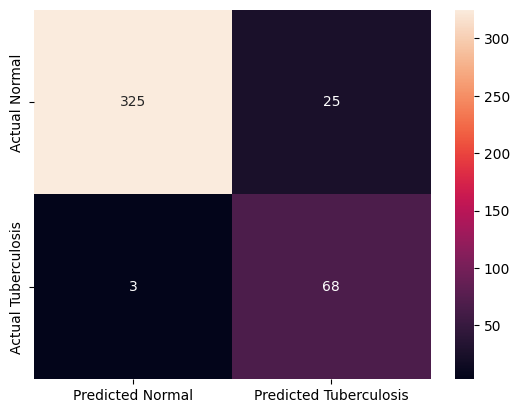

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.93      0.96       350
TUBERCULOSIS       0.73      0.96      0.83        71

    accuracy                           0.93       421
   macro avg       0.86      0.94      0.89       421
weighted avg       0.95      0.93      0.94       421



(421, 500, 500, 1)
(421,)


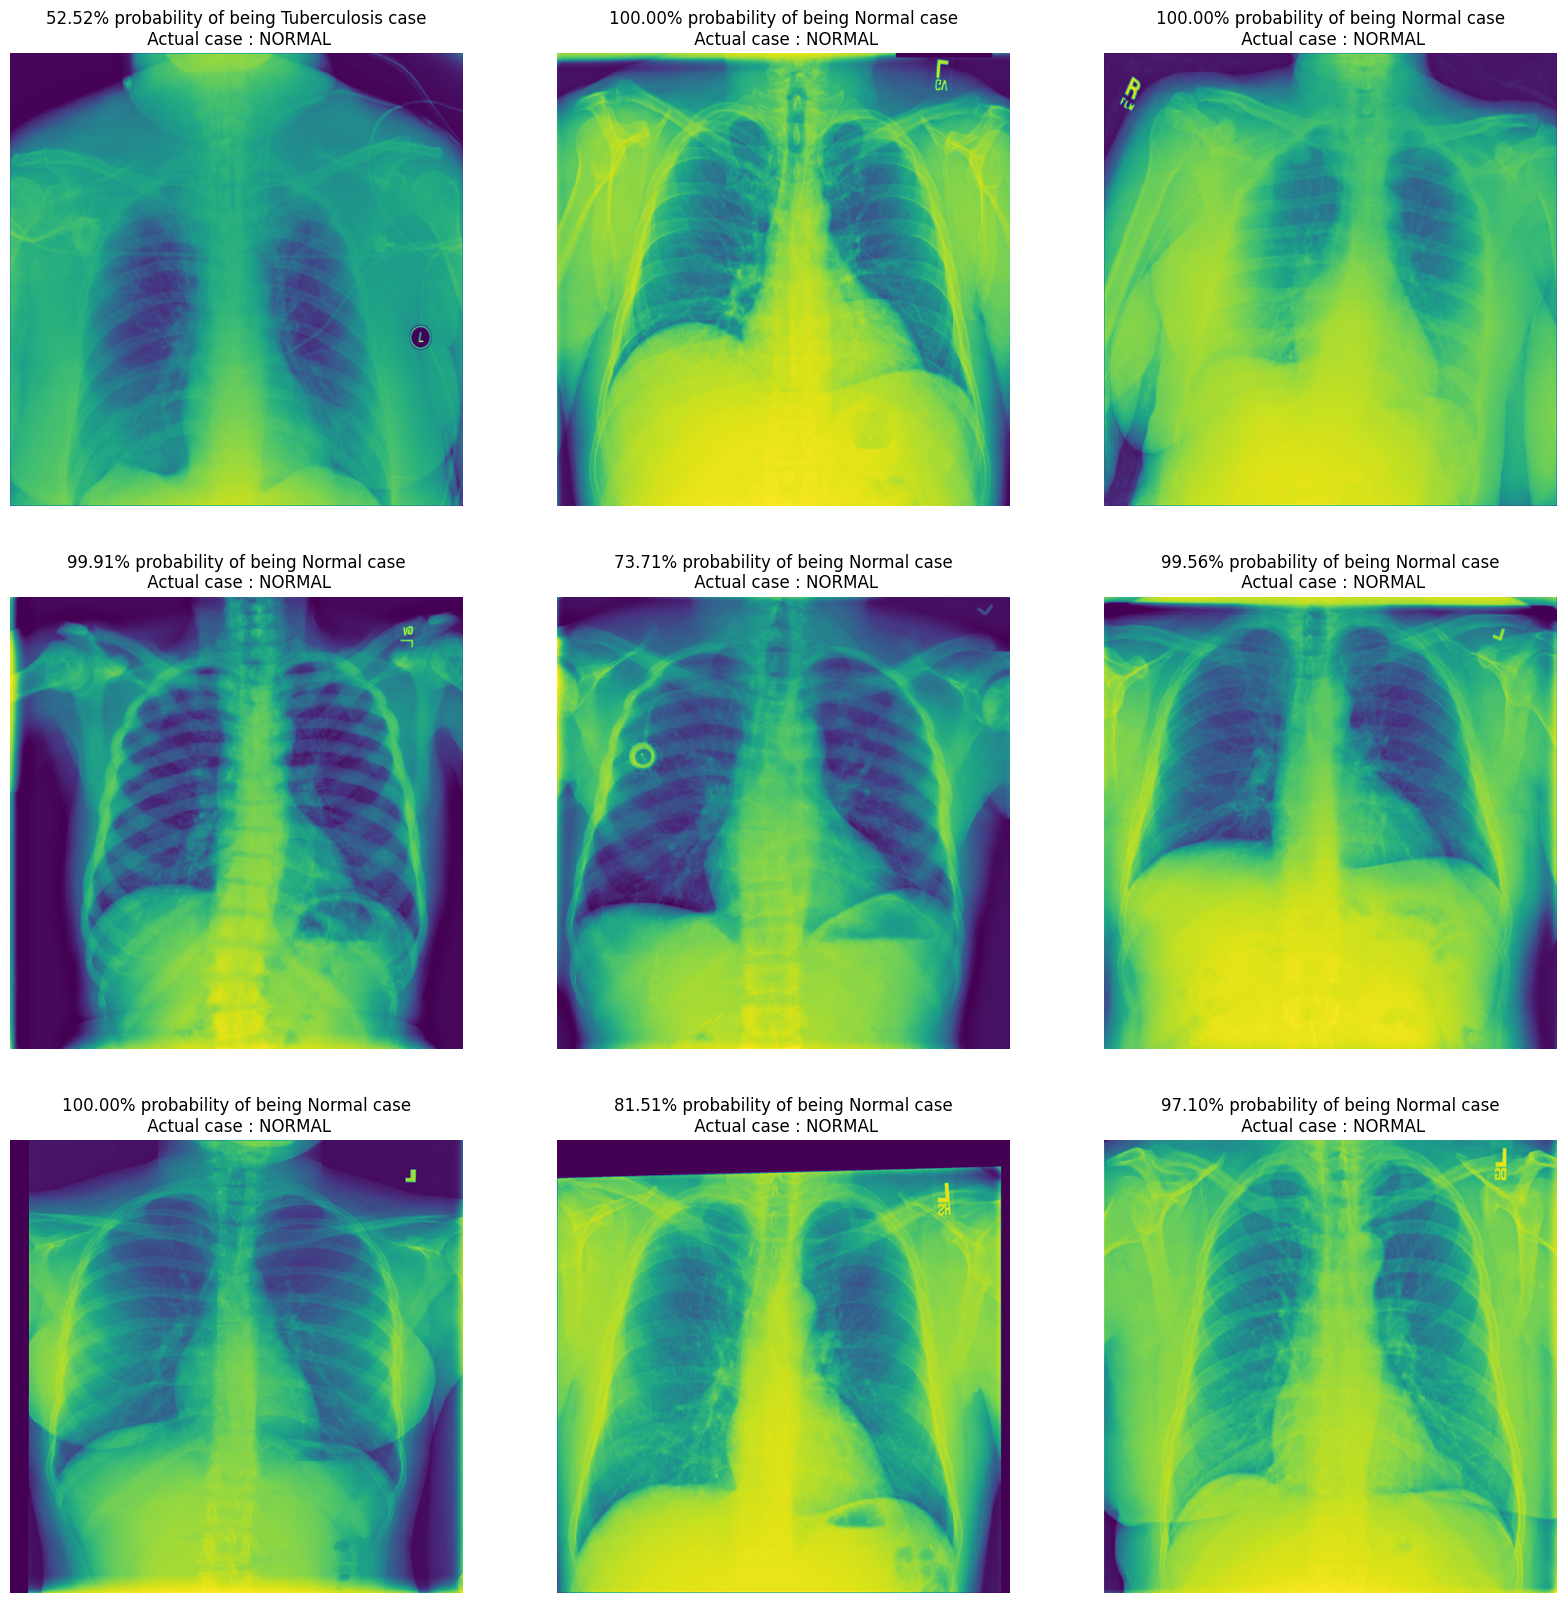

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels
dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
    out = ('{:.2%} probability of being Tuberculosis case'.format(preds[i][0]))


  else:
    out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()


# Resnet 50 based Transfer Learning

In [ ]:
train = image_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

valid = test_data_gen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size
)


Found 2939 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load the ResNet50 model pre-trained on ImageNet data
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers except for the last 10 layers
for layer in resnet.layers[:]:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet50 base model
model.add(resnet)

# Add Flatten layer
model.add(Flatten())

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


94765736/94765736 [==============================] - 1s 0us/step


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 128)               12845184  
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 36441217 (139.01 MB)
Trainable params: 12853505 (49.03 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

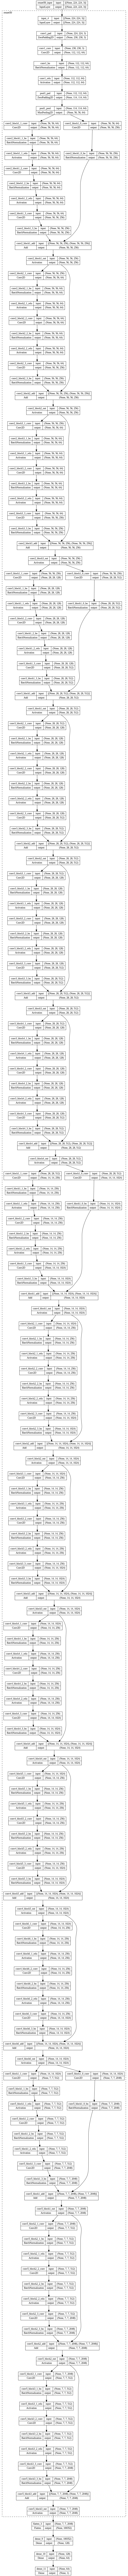

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight="balanced", classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 0.5997959183673469, 1: 3.005112474437628}


In [ ]:
model.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
184/184 [==============================] - 47s 221ms/step - loss: 0.8135 - accuracy: 0.5468 - val_loss: 0.7758 - val_accuracy: 0.3155 - lr: 0.0010
Epoch 2/25
184/184 [==============================] - 39s 214ms/step - loss: 0.6145 - accuracy: 0.6655 - val_loss: 0.7348 - val_accuracy: 0.5548 - lr: 0.0010
Epoch 3/25
184/184 [==============================] - 41s 221ms/step - loss: 0.5821 - accuracy: 0.6808 - val_loss: 0.9453 - val_accuracy: 0.3607 - lr: 0.0010
Epoch 4/25
184/184 [==============================] - 36s 198ms/step - loss: 0.5599 - accuracy: 0.7067 - val_loss: 0.3553 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 5/25
184/184 [==============================] - 40s 216ms/step - loss: 0.5002 - accuracy: 0.7775 - val_loss: 0.3266 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 6/25
184/184 [==============================] - 48s 261ms/step - loss: 0.4037 - accuracy: 0.8125 - val_loss: 0.2251 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 7/25
184/184 [==============================] 

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

27/27 [==============================] - 5s 186ms/step - loss: 0.1762 - accuracy: 0.9240
The testing accuracy is : 92.39904880523682 %


In [ ]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

27/27 [==============================] - 5s 159ms/step


<Axes: >

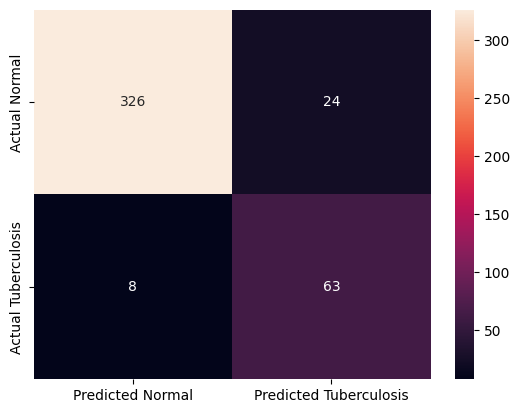

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.93      0.95       350
TUBERCULOSIS       0.72      0.89      0.80        71

    accuracy                           0.92       421
   macro avg       0.85      0.91      0.88       421
weighted avg       0.93      0.92      0.93       421



# VGG16

In [ ]:
train = image_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size
)

test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

valid = test_data_gen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=batch_size
)


Found 2939 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load the VGG16 model pre-trained on ImageNet data
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers except for the last 10 layers
for layer in vgg.layers[:]:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet50 base model
model.add(vgg)

# Add Flatten layer
model.add(Flatten())

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               3211392   
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17934401 (68.41 MB)
Trainable params: 3219713 (12.28 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

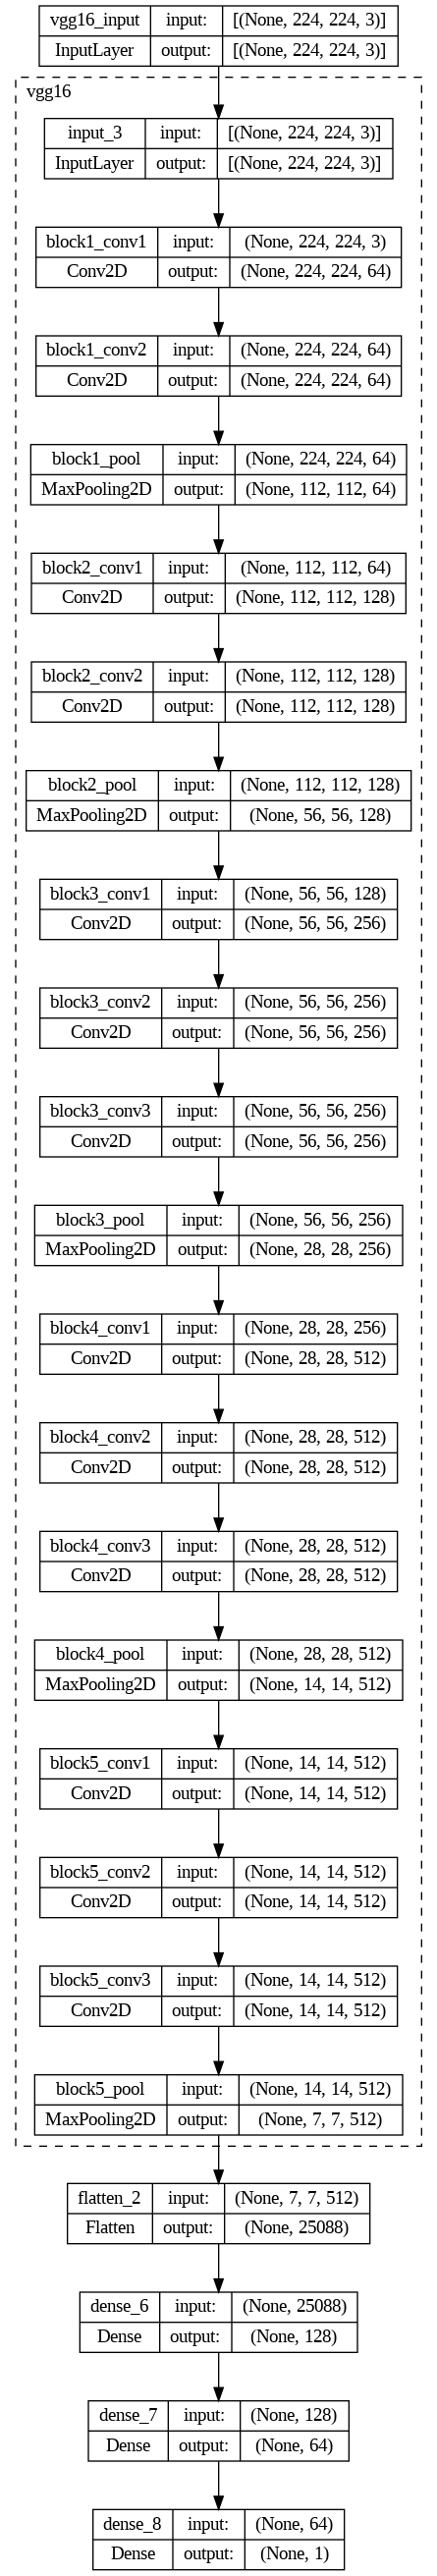

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
model.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
184/184 [==============================] - 38s 197ms/step - loss: 0.1883 - accuracy: 0.9245 - val_loss: 0.1042 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 2/25
184/184 [==============================] - 36s 196ms/step - loss: 0.0564 - accuracy: 0.9803 - val_loss: 0.0629 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 3/25
184/184 [==============================] - 37s 203ms/step - loss: 0.0392 - accuracy: 0.9840 - val_loss: 0.0307 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 4/25
184/184 [==============================] - 37s 199ms/step - loss: 0.0524 - accuracy: 0.9813 - val_loss: 0.0190 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 5/25
184/184 [==============================] - 37s 203ms/step - loss: 0.0167 - accuracy: 0.9939 - val_loss: 0.0216 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 6/25
184/184 [==============================] - 37s 201ms/step - loss: 0.0134 - accuracy: 0.9942 - val_loss: 0.0132 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 7/25
184/184 [==============================] 

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

27/27 [==============================] - 10s 352ms/step - loss: 0.0138 - accuracy: 0.9929
The testing accuracy is : 99.28740859031677 %


In [ ]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

27/27 [==============================] - 7s 233ms/step


<Axes: >

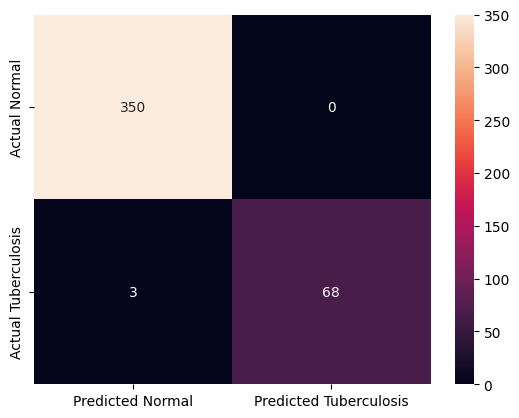

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.99      1.00      1.00       350
TUBERCULOSIS       1.00      0.96      0.98        71

    accuracy                           0.99       421
   macro avg       1.00      0.98      0.99       421
weighted avg       0.99      0.99      0.99       421



# ConvNext Base Model

In [ ]:
from keras.applications import ConvNeXtBase
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load the ConvNeXtBase model pre-trained on ImageNet data
convnext = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers except for the last 10 layers
for layer in convnext.layers[:]:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the ResNet50 base model
model.add(convnext)

# Add Flatten layer
model.add(Flatten())

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


350926856/350926856 [==============================] - 6s 0us/step


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               6422656   
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 93997441 (358.57 MB)
Trainable params: 6430977 (24.53 MB)
Non-trainable params: 87566464 (334.04 MB)
_________________________________________________________________


In [ ]:
model.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
184/184 [==============================] - 149s 634ms/step - loss: 0.7825 - accuracy: 0.7503 - val_loss: 1.1704 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 2/25
184/184 [==============================] - 75s 406ms/step - loss: 0.4316 - accuracy: 0.7880 - val_loss: 0.3507 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 3/25
184/184 [==============================] - 74s 404ms/step - loss: 0.3358 - accuracy: 0.8203 - val_loss: 0.2116 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 4/25
184/184 [==============================] - 73s 398ms/step - loss: 0.3025 - accuracy: 0.8459 - val_loss: 0.3331 - val_accuracy: 0.8345 - lr: 0.0010
Epoch 5/25
184/184 [==============================] - 73s 397ms/step - loss: 0.2933 - accuracy: 0.8527 - val_loss: 0.2408 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 6/25
184/184 [==============================] - 73s 397ms/step - loss: 0.2676 - accuracy: 0.8687 - val_loss: 0.2017 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 7/25
184/184 [==============================]

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

27/27 [==============================] - 11s 406ms/step - loss: 0.2582 - accuracy: 0.9145
The testing accuracy is : 91.44893288612366 %


In [ ]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

27/27 [==============================] - 11s 295ms/step


<Axes: >

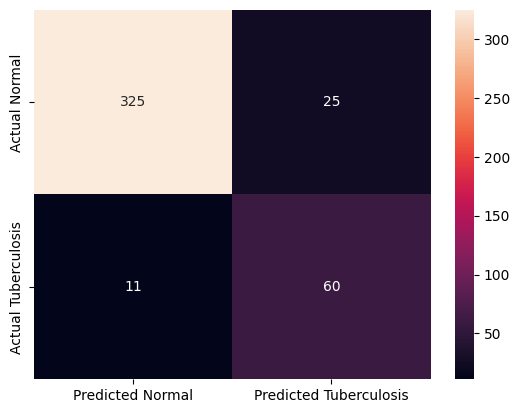

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.93      0.95       350
TUBERCULOSIS       0.71      0.85      0.77        71

    accuracy                           0.91       421
   macro avg       0.84      0.89      0.86       421
weighted avg       0.92      0.91      0.92       421



# Different Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Batch normalization and dropout
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 496, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 248, 248, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 246, 246, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 244, 244, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 122, 122, 64)      0         
 g2D)                                                 

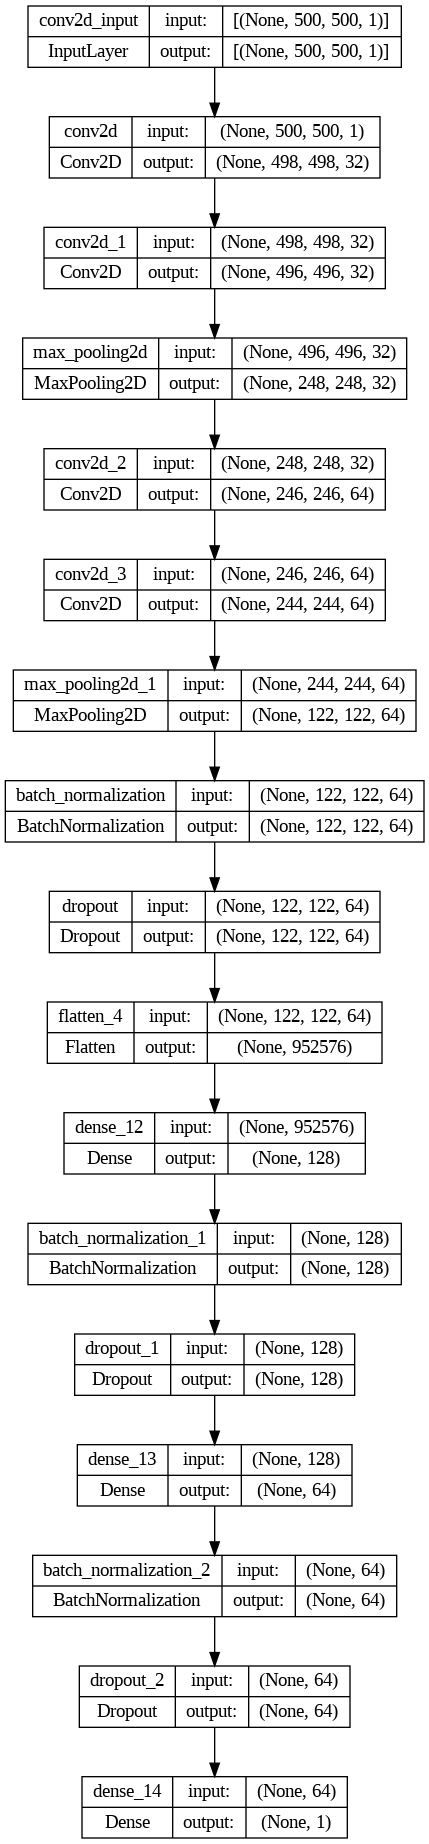

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
model.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
184/184 [==============================] - 108s 494ms/step - loss: 0.5471 - accuracy: 0.7230 - val_loss: 2.2107 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/25
184/184 [==============================] - 81s 438ms/step - loss: 0.3880 - accuracy: 0.8125 - val_loss: 1.0307 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 3/25
184/184 [==============================] - 83s 451ms/step - loss: 0.3289 - accuracy: 0.8551 - val_loss: 0.9641 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 4/25
184/184 [==============================] - 82s 444ms/step - loss: 0.3082 - accuracy: 0.8673 - val_loss: 0.3211 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 5/25
184/184 [==============================] - 81s 440ms/step - loss: 0.2954 - accuracy: 0.8785 - val_loss: 0.7088 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 6/25
184/184 [==============================] - 81s 442ms/step - loss: 0.2762 - accuracy: 0.8911 - val_loss: 0.1864 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 7/25
184/184 [==============================]

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

27/27 [==============================] - 8s 298ms/step - loss: 0.4784 - accuracy: 0.7743
The testing accuracy is : 77.43467688560486 %


In [ ]:
preds = model.predict(test,verbose=1)

27/27 [==============================] - 5s 164ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

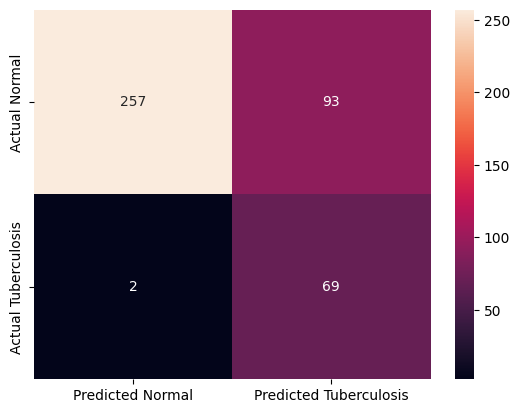

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.73      0.84       350
TUBERCULOSIS       0.43      0.97      0.59        71

    accuracy                           0.77       421
   macro avg       0.71      0.85      0.72       421
weighted avg       0.90      0.77      0.80       421



# ConvLSTSM Model

In [ ]:
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

time_steps = 1  # Adjust this based on your requirements

# Load and preprocess the training data
def load_data_from_directory(directory, time_steps):
    X_data = []
    y_data = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.png'):  # Assuming images are in PNG format
                img_path = os.path.join(subdir, file)
                img = load_img(img_path, color_mode='grayscale', target_size=(img_height, img_width))
                img_array = img_to_array(img) / 255.0  # Normalize pixel values
                X_data.append(img_array)
                label = 1 if 'positive' in subdir else 0  # Assuming positive examples are in a subdirectory named 'positive'
                y_data.append(label)

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    # Reshape X_data to create sequences of images
    X_data = X_data.reshape(-1, time_steps, img_height, img_width, 1)

    return X_data, y_data

# Load training data
train_X, train_y = load_data_from_directory(train_path, time_steps)

# Load validation data
valid_X, valid_y = load_data_from_directory(valid_path, time_steps)

# Load test data
test_X, test_y = load_data_from_directory(test_path, time_steps)

In [ ]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D, Flatten, Dense

# Define model architecture
model = Sequential()

# Convolutional layers
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(1, img_width, img_height, 1)))

# Max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 498, 498, 32)      38144     
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1984032)           0         
                                                                 
 dense (Dense)               (None, 128)               253956224 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                        

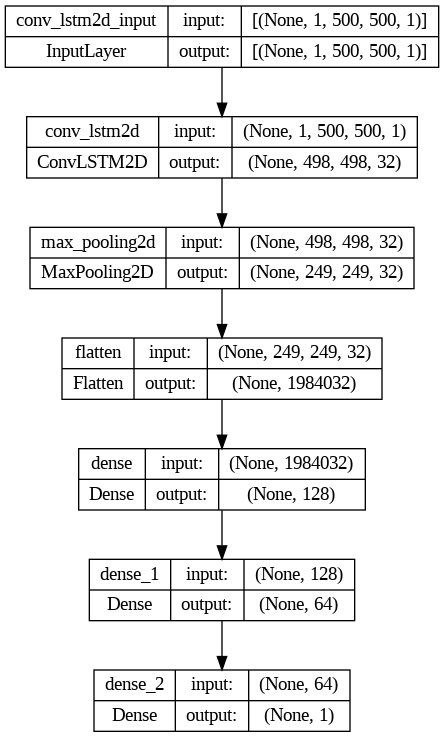

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
model.fit(train_X, train_y, epochs=25, batch_size=4, validation_data=(valid_X, valid_y), class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
735/735 [==============================] - 221s 286ms/step - loss: 5.7192e-04 - accuracy: 0.9986 - val_loss: 2.4783e-24 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/25
735/735 [==============================] - 215s 292ms/step - loss: 5.7022e-27 - accuracy: 1.0000 - val_loss: 2.4783e-24 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/25
735/735 [==============================] - 208s 282ms/step - loss: 5.7022e-27 - accuracy: 1.0000 - val_loss: 2.4783e-24 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/25
735/735 [==============================] - 215s 292ms/step - loss: 5.7022e-27 - accuracy: 1.0000 - val_loss: 2.4783e-24 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/25
735/735 [==============================] - ETA: 0s - loss: 5.7022e-27 - accuracy: 1.0000
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
735/735 [==============================] - 215s 293ms/step - loss: 5.7022e-27 - accuracy: 1.0000 - val_loss: 2.4783e-24 - val_accuracy: 1.0000 - lr: 0.0010


In [ ]:
from google.colab import drive
from keras.callbacks import ModelCheckpoint

# Define the path to save the model weights in your Google Drive
filepath = "/content/drive/My Drive/model__tuber_weights.h5"

# Define ModelCheckpoint callback to save the best model weights during training
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [ early, learning_rate_reduction, checkpoint]
# Train the model
history = model.fit(train_X, train_y, epochs=25, batch_size=4, validation_data=(valid_X, valid_y), class_weight=cw, callbacks=callbacks_list)

# Save final weights to the specified location
model.save_weights(filepath)


Epoch 1/25
735/735 [==============================] - ETA: 0s - loss: 5.7090e-04 - accuracy: 0.9986
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/My Drive/model__tuber_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Set batch size for evaluation
batch_size = 4

# Evaluate the model on the test data in batches
test_loss, test_accuracy = model.evaluate(test_X, test_y, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


106/106 [==============================] - 8s 71ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Loss: 0.0
Test Accuracy: 1.0


In [ ]:
preds = model.predict(test_X, batch_size=4, verbose=1)

106/106 [==============================] - 7s 66ms/step


# **On Main Dataset**

In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.56G/9.58G [01:56<00:00, 119MB/s] 
100% 9.58G/9.58G [01:56<00:00, 88.1MB/s]


In [ ]:
! unzip /content/chest-xray-masks-and-labels.zip

In [ ]:
import os
import shutil

# Define the path to the dataset folder
dataset_folder = "/content/Lung Segmentation/CXR_png"

# Create folders for normal and pneumonia images
normal_folder = os.path.join(dataset_folder, "normal")
pneumonia_folder = os.path.join(dataset_folder, "pneumonia")
os.makedirs(normal_folder, exist_ok=True)
os.makedirs(pneumonia_folder, exist_ok=True)

# Loop through the files in the dataset folder
for filename in os.listdir(dataset_folder):
    if filename.endswith(".png"):
        last_number = int(filename.split(".png")[0].split("_")[-1])  # Extract the last number before ".png"
        if last_number == 0:  # Check if the image is normal
            shutil.move(os.path.join(dataset_folder, filename), os.path.join(normal_folder, filename))
        elif last_number == 1:  # Check if the image is pneumonia
            shutil.move(os.path.join(dataset_folder, filename), os.path.join(pneumonia_folder, filename))


In [ ]:
print(len(os.listdir('/content/Lung Segmentation/CXR_png/pneumonia')))

394


In [ ]:
print(len(os.listdir('/content/Lung Segmentation/CXR_png/normal')))

406


In [ ]:
import splitfolders

splitfolders.ratio(
    "/content/Lung Segmentation/CXR_png",
    output="/content/dataset/tuberculosis",
    seed=1337,
    ratio=(.7, .2, .1),
    group_prefix=None
)


Copying files: 800 files [00:31, 25.03 files/s]


In [ ]:
!rm -r "/content/data"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/dataset/tuberculosis/train'
test_path = '/content/dataset/tuberculosis/test'
valid_path = '/content/dataset/tuberculosis/val'

In [ ]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 559 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


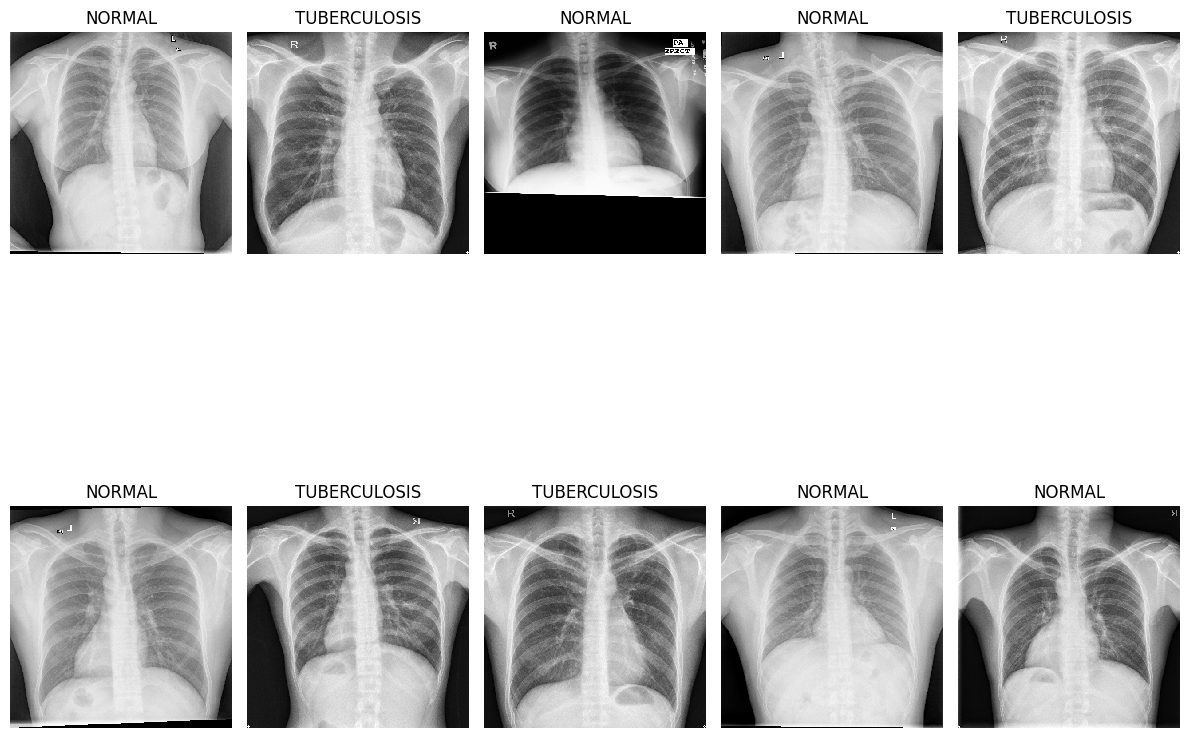

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 32)        0

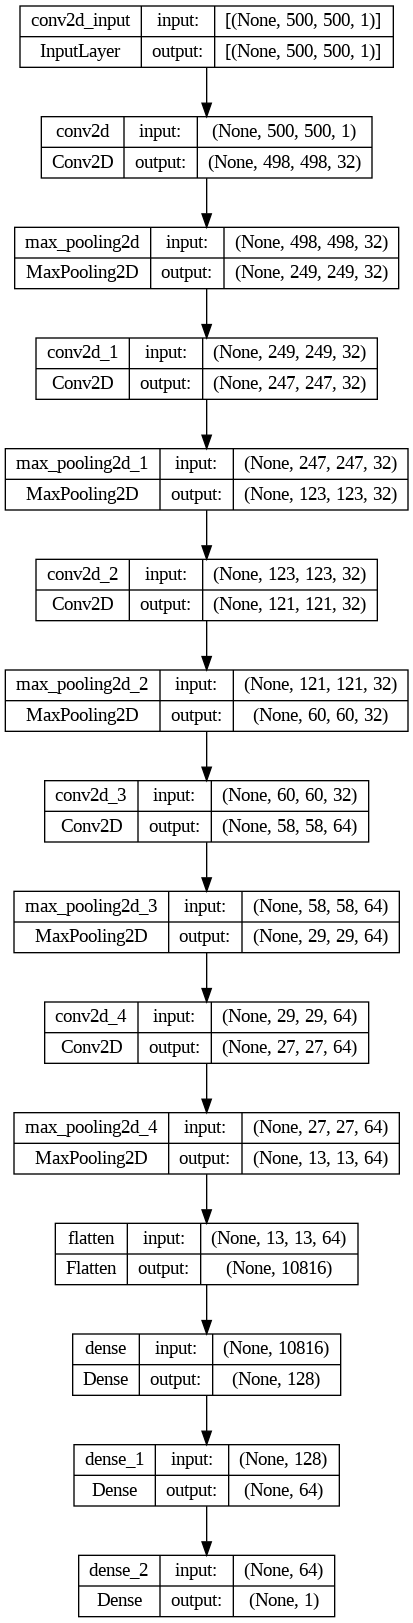

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 4)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight="balanced", classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 0.9841549295774648, 1: 1.0163636363636364}


In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
35/35 [==============================] - 97s 2s/step - loss: 0.6964 - accuracy: 0.4919 - val_loss: 0.6915 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 2/25
35/35 [==============================] - 86s 2s/step - loss: 0.6906 - accuracy: 0.5528 - val_loss: 0.6755 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 3/25
35/35 [==============================] - 81s 2s/step - loss: 0.6537 - accuracy: 0.6386 - val_loss: 0.5832 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 4/25
35/35 [==============================] - 81s 2s/step - loss: 0.6108 - accuracy: 0.6816 - val_loss: 0.5562 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 5/25
35/35 [==============================] - 81s 2s/step - loss: 0.5521 - accuracy: 0.7406 - val_loss: 0.5523 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 6/25
35/35 [==============================] - 82s 2s/step - loss: 0.5164 - accuracy: 0.7478 - val_loss: 0.5218 - val_accuracy: 0.7358 - lr: 0.0010
Epoch 7/25
35/35 [==============================] - 81s 2s/step - loss: 0.5093 - a

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

6/6 [==============================] - 16s 2s/step - loss: 0.4061 - accuracy: 0.7683
The testing accuracy is : 76.82926654815674 %


In [ ]:
preds = cnn.predict(test,verbose=1)

6/6 [==============================] - 13s 2s/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

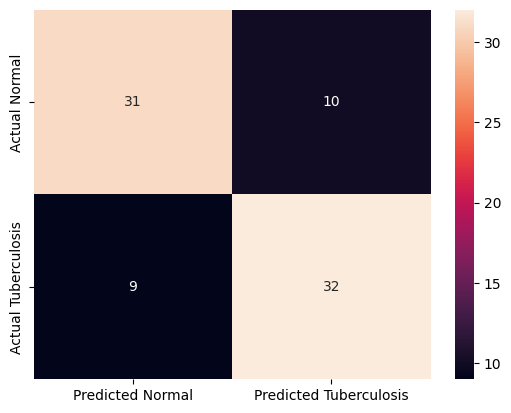

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")